In [3]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils
from torch import nn
from torch import optim
import torchvision.transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Loading MNIST (training only, as we do unsupervised learning with autoencoders)

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
    ])
)

# Creating a dataloader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [86]:
nz = 30 # number of latent variables
nf = 64
lr = 1e-3
num_epochs = 30

In [91]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
         
        # Building an encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.Conv2d(nf, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.Conv2d(nf, nf * 2, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 2),
            # 128 x 16 x 16
            nn.Conv2d(nf * 2, nf * 4, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 4),
            # 256 x 8 x 8
            nn.Conv2d(nf * 4, nf * 8, 5, 2, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 8),
            # 512 x 4 x 4
            nn.Conv2d(nf * 8, nz, 4, 1, 0, bias=False),
            # nz x 1 x 1
            nn.Flatten()
        )

        # z mean and logvar
        self.z_mean = nn.Linear(nz, nz)
        self.z_logvar = nn.Linear(nz, nz)

        
        # Building a decoder 
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (nz, 1, 1)),
            nn.ConvTranspose2d(nz, nf * 8, 4, 1, 0, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 8),
            # 512 x 4 x 4
            nn.ConvTranspose2d(nf * 8, nf * 4, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 4),
            # 256 x 8 x 8
            nn.ConvTranspose2d(nf * 4, nf * 2, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf * 2),
            # 128 x 16 x 16
            nn.ConvTranspose2d(nf * 2, nf, 5, 2, 2, bias=False, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.ConvTranspose2d(nf, nf, 5, 1, 2, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(nf),
            # 64 x 32 x 32
            nn.ConvTranspose2d(nf, 1, 5, 1, 2, bias=False),
            nn.Sigmoid()
            # 1 x 32 x 32
        )

    def reparameterize(self, z_mu, z_logvar):
        eps = torch.randn_like(z_mu)
        return z_mu + eps * torch.exp(z_logvar / 2)
 
    def forward(self, x):
        encoded = self.encoder(x)
        z_mean, z_logvar = self.z_mean(encoded), self.z_logvar(encoded)
        encoded = self.reparameterize(z_mean, z_logvar)
        decoded = self.decoder(encoded)
        return z_mean, z_logvar, decoded

def loss_kl_bce(pred, target, mu, logvar, beta=1.0):
    mse = F.binary_cross_entropy(pred, target, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + beta * kl

In [17]:
## below is a simple VAE, train time is quicker

# class VAE(nn.Module):
#     def __init__(self):
#         super().__init__()
         
#         # Building an encoder
#         self.encoder = torch.nn.Sequential(
#             nn.Conv2d(1, 16, 3, padding=1), # 28 x 28 x 1 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.Conv2d(16, 16, 3, padding=1), # 28 x 28 x 16 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, padding=1, stride=2), # 28 x 28 x 16 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.Conv2d(32, 32, 3, padding=1), # 14 x 14 x 32 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, padding=1, stride=2), # 14 x 14 x 32 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.Conv2d(64, 64, 3, padding=1), # 7 x 7 x 64 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.Flatten(start_dim=1), # 7 x 7 x 64 ==> 64 * 7 * 7
#             nn.Linear(64 * 7 * 7, 200), # 64 * 7 * 7 ==> 200
#             nn.ReLU(),
#             nn.Linear(200, 30),
#             nn.ReLU(),
#         )

#         # z mean and logvar
#         self.z_mean = nn.Linear(30, 30)
#         self.z_logvar = nn.Linear(30, 30)
        
#         # Building a decoder 
#         self.decoder = torch.nn.Sequential(
#             nn.Unflatten(dim=1, unflattened_size=(nz, 1, 1)),
#             nn.Linear(30, 200),
#             nn.ReLU(),
#             nn.Linear(200, 64 * 7 * 7), # 200 ==> 64 * 7 * 7
#             nn.ReLU(),
#             nn.Unflatten(1, (64, 7, 7)), # 64 * 7 * 7 ==> 7 x 7 x 64
#             nn.ConvTranspose2d(64, 64, 3, padding=1), # 7 x 7 x 64 ==> 7 x 7 x 64
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1), # 7 x 7 x 64 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 32, 3, padding=1), # 14 x 14 x 32 ==> 14 x 14 x 32
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, padding=1, stride=2, output_padding=1), # 14 x 14 x 32 ==> 28 x 28 x 16
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, padding=1),
#             nn.Sigmoid(),
#         )

#     def reparameterize(self, z_mu, z_logvar):
#         eps = torch.randn_like(z_mu)
#         return z_mu + eps * torch.exp(z_logvar / 2)
 
#     def forward(self, x):
#         encoded = self.encoder(x)
#         z_mean, z_logvar = self.z_mean(encoded), self.z_logvar(encoded)
#         encoded = self.reparameterize(z_mean, z_logvar)
#         decoded = self.decoder(encoded)
#         return z_mean, z_logvar, decoded

# def loss_kl_bce(pred, target, mu, logvar, beta=1.0):
#     mse = F.binary_cross_entropy(pred, target, reduction='sum')
#     kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return mse + beta * kl

In [92]:
model = VAE().to(device)
# loss_fn will be BCELoss
# loss_fn = nn.MSELoss(reduction='sum')
# loss_fn = nn.BCELoss(reduction='sum')
loss_fn = loss_kl_bce
optimizer = optim.Adam(params=model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [93]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch, (X, _) in enumerate(train_loader):
        X = X.to(device)

        # forward pass
        z_mean, z_logvar, decoded = model(X)
        loss = loss_fn(decoded, X, z_mean, z_logvar, beta=0.5)
        total_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

    # printing the loss
    print("Epoch: {}, Loss: {}".format(epoch, total_loss / (batch + 1)))

Epoch: 0, Loss: 12967.482148583256
Epoch: 1, Loss: 9084.170313853445
Epoch: 2, Loss: 8725.1758223739
Epoch: 3, Loss: 8574.686228802972
Epoch: 4, Loss: 8491.977921670943
Epoch: 5, Loss: 8435.004042635594
Epoch: 6, Loss: 8395.002472119037
Epoch: 7, Loss: 8351.318841409582
Epoch: 8, Loss: 8318.178821815865
Epoch: 9, Loss: 8286.679878023388
Epoch: 10, Loss: 8118.172164949527
Epoch: 11, Loss: 8111.878853153318
Epoch: 12, Loss: 8105.775785726779
Epoch: 13, Loss: 8092.78606253748
Epoch: 14, Loss: 8078.808665066132
Epoch: 15, Loss: 8065.3620100529715
Epoch: 16, Loss: 8047.639266089335
Epoch: 17, Loss: 8035.85273166811
Epoch: 18, Loss: 8022.931880861457
Epoch: 19, Loss: 8013.381664154118
Epoch: 20, Loss: 7935.924982977828
Epoch: 21, Loss: 7922.298505380464
Epoch: 22, Loss: 7918.058355335488
Epoch: 23, Loss: 7910.507093872851
Epoch: 24, Loss: 7901.0525573860605
Epoch: 25, Loss: 7897.246738718517
Epoch: 26, Loss: 7891.938906541512
Epoch: 27, Loss: 7886.245455028152
Epoch: 28, Loss: 7880.321549340

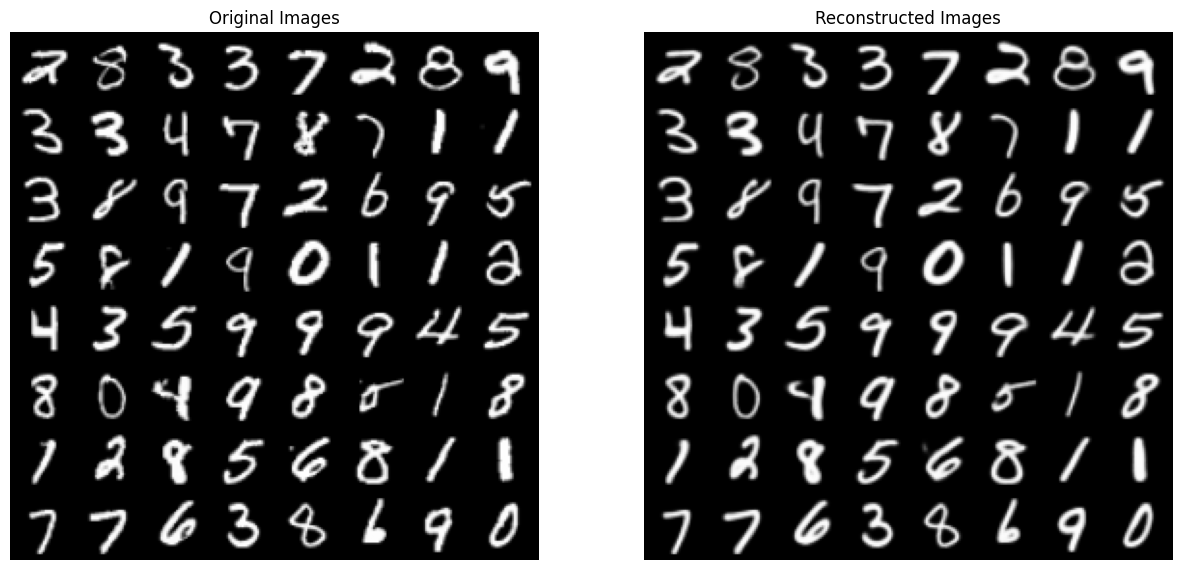

In [94]:
model.eval()

sample_data = next(iter(train_loader))[0].to(device)
_, _, sample_output = model(sample_data)

img_grid = torchvision.utils.make_grid(sample_output.detach().cpu(), nrow=8)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_data.detach().cpu(), nrow=8), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Reconstructed Images')
plt.imshow(np.transpose(img_grid, (1, 2, 0)))
plt.show()

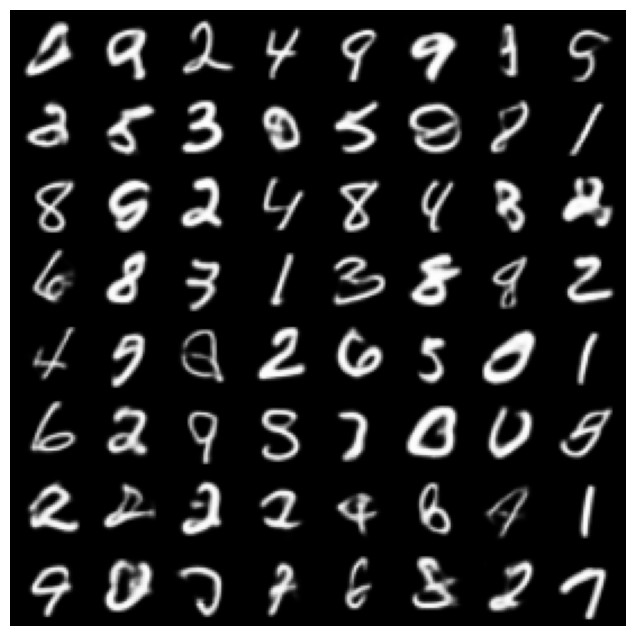

In [101]:
# now some VAE illusions, sampling from the latent space

model.eval()
random_illusions = torch.randn(64, 30).to(device)
with torch.no_grad():
    random_illusions = model.decoder(random_illusions).cpu()
    image_grid = torchvision.utils.make_grid(random_illusions, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(np.transpose(image_grid, (1, 2, 0)))